In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from aparent.losses.aparent_losses import *

from visualization.seqprop_visualization import *
from generator.seqprop_generator import *
from predictor.seqprop_predictor import *
from predictor.definitions.aparent_large_all_libs_with_dense import load_saved_predictor
from optimizer.seqprop_optimizer import *


Using TensorFlow backend.


In [21]:

#Define target isoform loss function
def get_deepdream_loss(target_neuron, target_bits=1.8, isoform_start=80, isoform_end=115, punish_up_aruns=False, punish_dn_gruns=False, punish_up_c=False, punish_dn_cse=False, punish_dn_aruns=False) :
    
    target_entropy_mse = get_target_entropy_mse(pwm_start=25, pwm_end=125, target_bits=target_bits)
    
    punish_up_c_func = get_punish_c(pwm_start=25, pwm_end=68)
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=125)
    punish_dn_aa_func = get_punish_aa(pwm_start=76, pwm_end=125)
    
    punish_up_aa_func = get_punish_aa(pwm_start=25, pwm_end=68)
    punish_dn_gg_func = get_punish_gg(pwm_start=76, pwm_end=125)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, _, cut_pred, iso_score_pred, cut_score_pred, dense_out = predictor_outputs

        #Maximize dense neuron activation
        deepdream_loss = 2.0 * -K.mean(dense_out[..., target_neuron], axis=0)
        
        #Specify costs
        seq_loss = 0.0
        
        if punish_up_c :
            seq_loss += 0.0015 * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        
        if punish_up_aruns :
            seq_loss += 0.0015 * K.mean(punish_up_aa_func(sampled_pwm), axis=0)
        
        if punish_dn_gruns :
            seq_loss += 0.0015 * K.mean(punish_dn_gg_func(sampled_pwm), axis=0)
        
        if punish_dn_cse :
            seq_loss += 1.0 * K.mean(punish_dn_cse_func(sampled_pwm), axis=0)
        
        if punish_dn_aruns :
            seq_loss += 0.0015 * K.mean(punish_dn_aa_func(sampled_pwm), axis=0)
        
        entropy_loss = 0.10 * target_entropy_mse(pwm) #0.25
        
        #Compute total loss
        total_loss = deepdream_loss + seq_loss + entropy_loss

        return K.sum(total_loss, axis=0)
    
    return loss_func


#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, loss_funcs, library_context, n_sequences=1, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    optimized_pwms = []
    optimized_cuts = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=205, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=True)
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=library_context), n_sequences=n_sequences, n_samples=n_samples, eval_mode='pwm')
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.1)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        #Specify callback entities
        callbacks =[
            EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            #SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=False, isoform_start=80, isoform_end=115, pwm_start=70-40, pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=[0])
        ]

        #Fit Loss Model
        train_history = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #Retrieve optimized PWMs and predicted cleavage distributionns
        _, optimized_pwm, _, _, cut_pred, _, _, _ = seqprop_predictor.predict(x=None, steps=1)
        
        optimized_pwms.append(optimized_pwm)
        optimized_cuts.append(cut_pred)

    return optimized_pwms, optimized_cuts



In [22]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../aparent/saved_models')
model_name = 'aparent_large_all_libs.h5'
model_path = os.path.join(save_dir, model_name)

In [23]:
#Optimize target isoform proportions for the 'Alien2' (aka 'Doubledope') library

seq_template = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNANNAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTAC'
library_context = 'doubledope'

neuron_objectives = np.arange(10, dtype=np.int).tolist()

#Run SeqProp Optimization

print("Running optimization experiment 'Alien2 Isoforms'")

#Number of PWMs to generate per objective
n_sequences = 1
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template
    for target_neuron in neuron_objectives
]

losses = [
    get_deepdream_loss(
        target_neuron,
        target_bits=1.5,
        punish_up_aruns=False,
        punish_dn_gruns= False,
        punish_up_c = False,
        punish_dn_aruns = False
    )
    for target_neuron in neuron_objectives
]

alien2_pwms, alien2_cuts = run_seqprop(sequence_templates, losses, library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)



Running optimization experiment 'Alien2 Isoforms'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 22s 11ms/step - loss: -3.7455
Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 23s 12ms/step - loss: 0.0196
Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 24s 12ms/step - loss: -2.4351
Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 24s 12ms/step - loss: -2.1958
Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 24s 12ms/step - loss: 0.0195
Optimizing objective 5...
Epoch 1/1
2000/2000 [==============================] - 25s 12ms/step - loss: 0.0197
Optimizing objective 6...
Epoch 1/1
2000/2000 [==============================] - 26s 13ms/step - loss: -5.5145
Optimizing objective 7...
Epoch 1/1
2000/2000 [==============================] - 28s 14ms/step - loss: 0.0196
Optimizing objective 8...
Epoch 1/1
2000/2000 [===================

Dense Neuron 0


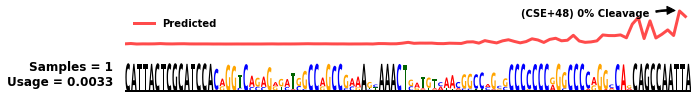

Dense Neuron 1


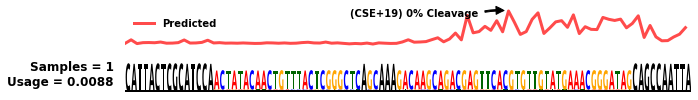

Dense Neuron 2


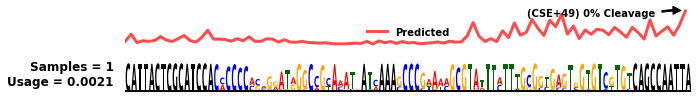

Dense Neuron 3


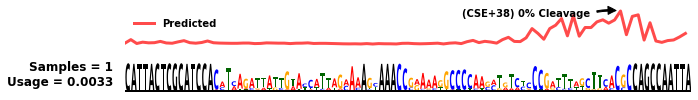

Dense Neuron 4


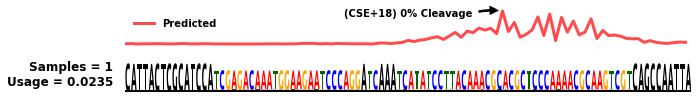

Dense Neuron 5


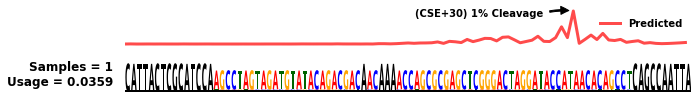

Dense Neuron 6


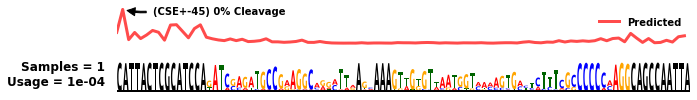

Dense Neuron 7


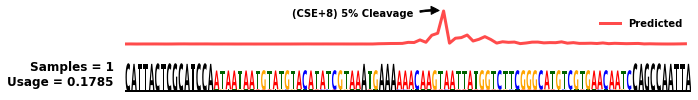

Dense Neuron 8


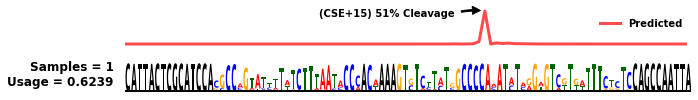

Dense Neuron 9


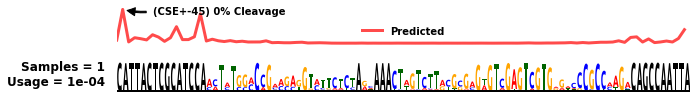

In [24]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Alien2 Isoforms')

pwms = alien2_pwms
cuts = alien2_cuts

pwm_index = 0 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    
    print("Dense Neuron " + str(obj_index))
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 80:115], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-40, plot_end=76+50)
